In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error


In [2]:
#read census data into pandas dataframe selecting only relevant columns
census_2011 = pd.read_csv('./2011-india-census/india-districts-census-2011.csv', usecols=list(range(1,9)) + list(range(25,26)) +  list(range(35,40)) + list(range(68,70)) + list(range(117,118)))

In [3]:
census_2011['Percentage of Housholds with a Computer'] = census_2011['Households_with_Computer']/census_2011['Households']

In [4]:
census_2011['Percentage of Owned Households'] = census_2011['Ownership_Owned_Households']/census_2011['Households']

In [5]:
#create new column representing male to female ratio of each district
census_2011['Male to Female Ratio'] = census_2011['Male']/census_2011['Female']

In [6]:
#create new column reprensenting percentage of literate population in entire population
census_2011['Total Literacy Rate'] = census_2011['Literate']/census_2011['Population']

In [7]:
#create new column representing percentage of urban households 
census_2011['Percetnage of Urban Households'] = census_2011['Urban_Households']/census_2011['Households']

In [8]:
census_2011['Percentage of Households with Internet'] = census_2011['Households_with_Internet']/census_2011['Households']

In [9]:
census_2011['Percentage Hindu'] = census_2011['Hindus']/census_2011['Population']

In [10]:
bins = [0, .33, .66, 1]
census_2011['Binned Hindu'] = pd.cut(census_2011['Percentage Hindu'], bins)
hindus = pd.get_dummies(census_2011['Binned Hindu'], drop_first=True)
census_2011 = pd.concat([census_2011, hindus], axis=1)

In [11]:
av = np.average(census_2011['Percentage of Owned Households'], weights = census_2011['Population'])
bins_av = [0,av,1]
census_2011['Binned Ownership'] = pd.cut(census_2011['Percentage of Owned Households'], bins_av)
ownership = pd.get_dummies(census_2011['Binned Ownership'],drop_first=True)
census_2011 = pd.concat([census_2011,ownership], axis = 1)

In [12]:
census_2011=census_2011.drop(columns=['Binned Ownership', 'Binned Hindu', 'Percentage Hindu'])

In [13]:
#select only relevant columns (purchase power parity, literacy rate, male to female ratio, percentage of urban households, percentage of households with computers)
data = census_2011.iloc[:, -10:]
# data = pd.DataFrame(census_2011['Percentage of Owned Households'])
# separate y target 
target = census_2011['Total Literacy Rate']
# drop target leaving only features to build model on
features = data.drop(columns=['Total Literacy Rate'])
# features = data

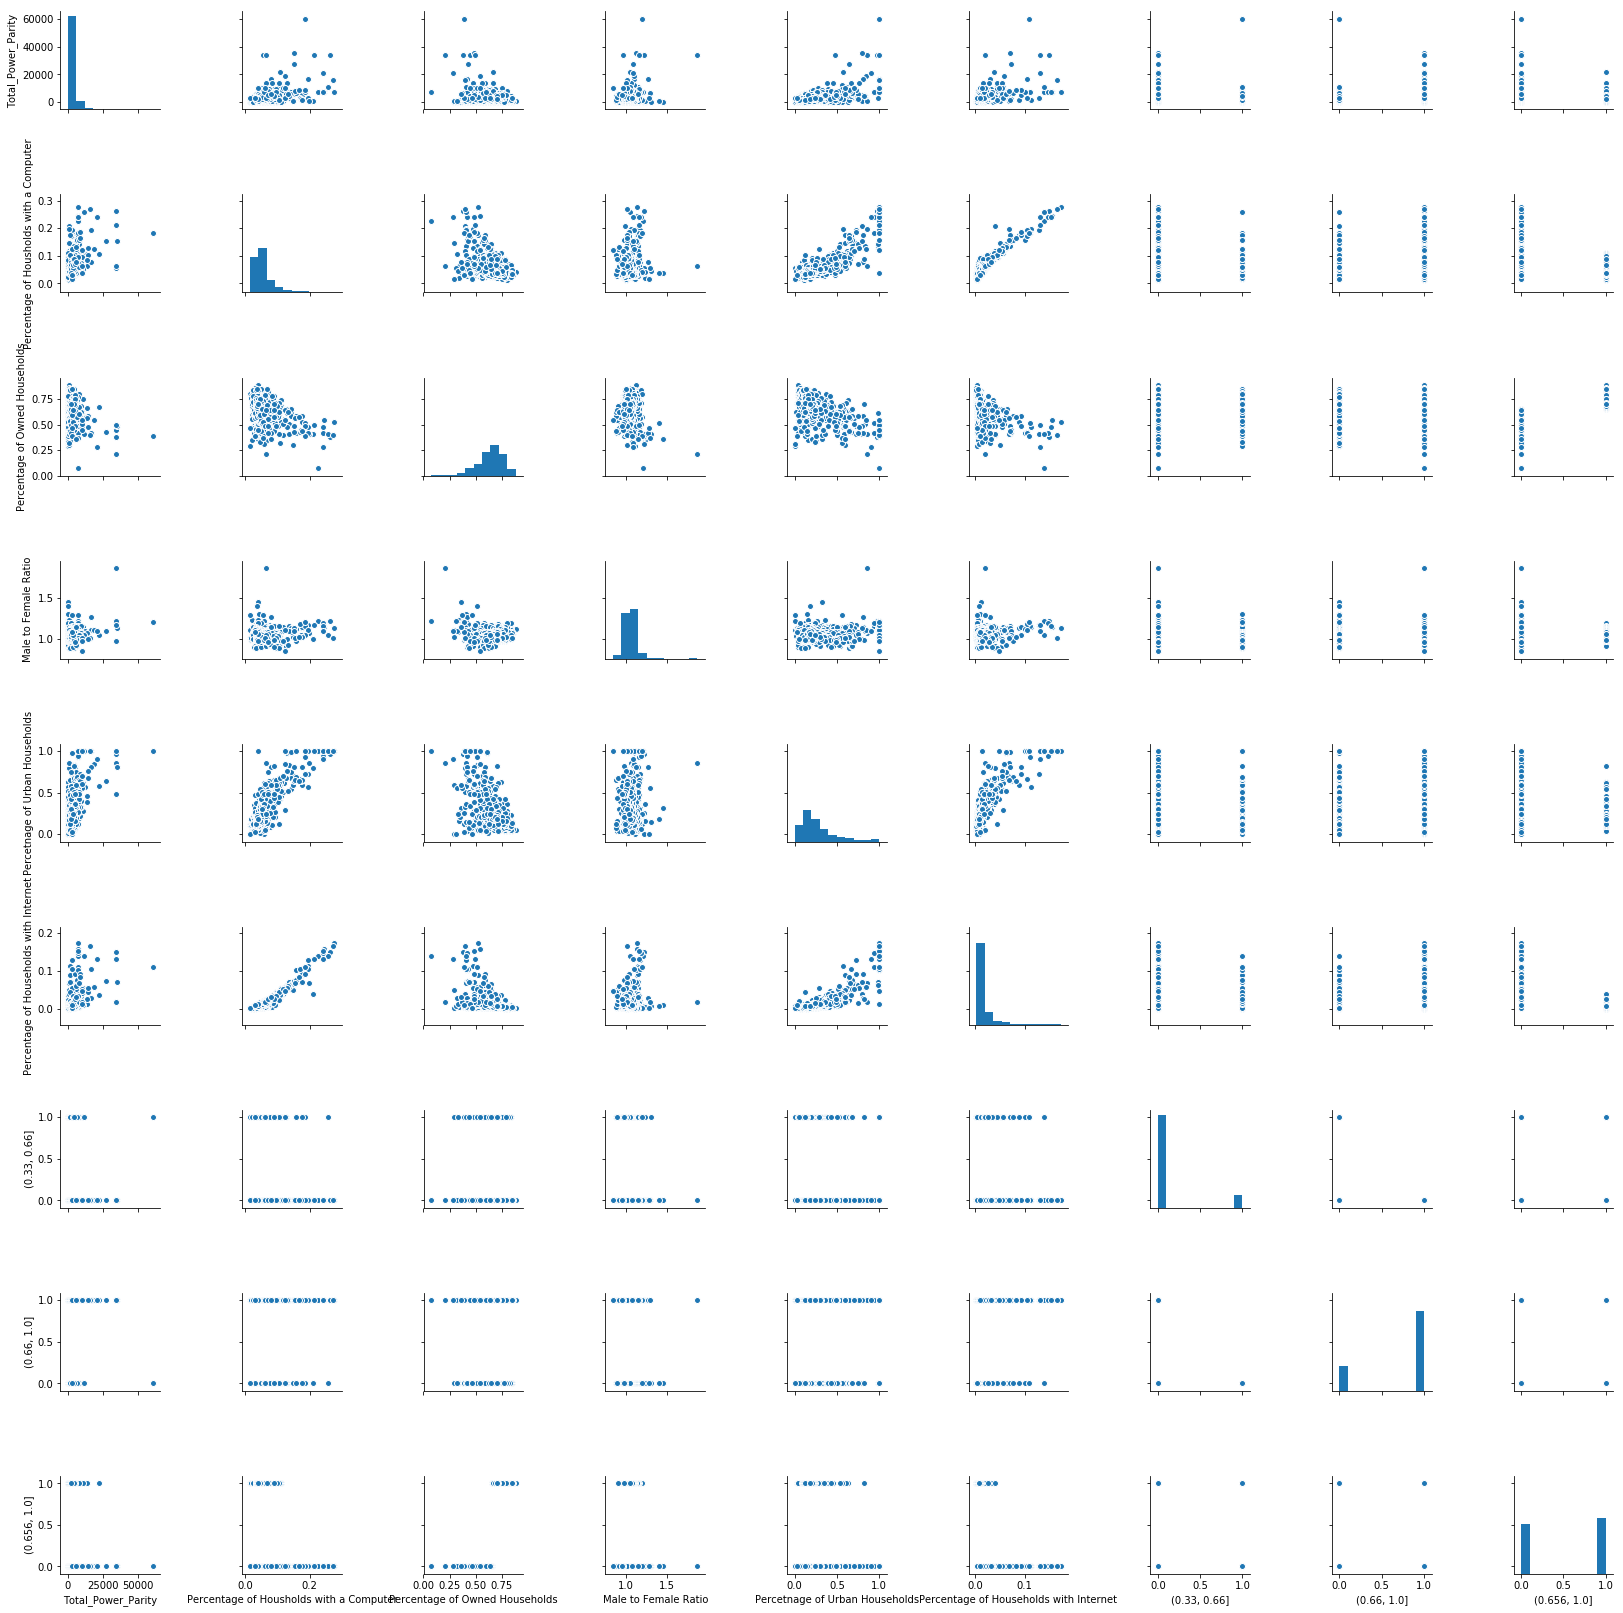

In [14]:
sns.pairplot(features)

In [15]:
#split training and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [16]:
#initialize Linear Regression model 
lr = linear_model.LinearRegression()

In [17]:
#fit data to model
model = lr.fit(X_train, y_train)

In [18]:
#run test data through Model and test outputs equal to y_pred
y_pred = model.predict(X_test)


In [19]:
#model score (R^2)
r2 = model.score(X_test, y_test)
ar2 = 1 - (1-model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

In [20]:
print(r2, ar2)

0.5412622756545789 0.5062738051536568


Text(0,0.5,'Predictions')

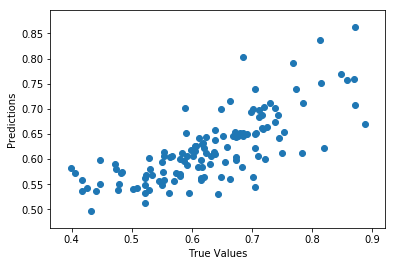

In [21]:
#residual plot
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [22]:
model.coef_

array([ 9.65183337e-07,  8.50170332e-01, -2.91313655e-01, -2.95838263e-01,
        1.54200086e-01, -1.05960961e+00,  2.78017927e-02,  2.72192297e-02,
       -4.28117832e-03])

In [23]:
selector = RFE(model, n_features_to_select = 1)
selector = selector.fit(features, target)
selector.ranking_

array([9, 1, 2, 3, 5, 4, 7, 6, 8])

In [24]:
cv_5_results = np.mean((cross_val_score(model, features, target, cv=5)))
cv_10_results = np.mean((cross_val_score(model, features, target, cv=10)))
cv_20_results = np.mean((cross_val_score(model, features, target, cv=20)))

In [25]:
print(cv_5_results, cv_10_results, cv_20_results)

0.13646975517742801 0.09213384220784178 0.0004612881194525298


In [26]:
from sklearn import preprocessing
from sklearn import pipeline
scaler = preprocessing.StandardScaler()

In [27]:
scaler.fit(X_train.iloc[:,:-3])
features_scaled_train = pd.DataFrame(scaler.transform(X_train.iloc[:,:-3]), columns = X_train.columns[:-3], index = X_train.index)
cat_variables = X_train.iloc[:, -3:]
features_scaled_train = pd.concat([features_scaled_train, cat_variables], axis=1)
# census_2011 = pd.concat([census_2011, hindus], axis=1)

In [28]:
scaler.fit(X_test.iloc[:,:-3])
features_scaled_test = pd.DataFrame(scaler.transform(X_test.iloc[:,:-3]), columns = X_test.columns[:-3], index = X_test.index)
cat_variables_test = X_test.iloc[:, -3:]
features_scaled_test = pd.concat([features_scaled_test, cat_variables_test], axis=1)

In [29]:
features_scaled_train.rename(columns={features_scaled_train.columns[6]: 'HINDUS ZERO TO 33%', features_scaled_train.columns[7]: 'HINDUS 66% TO 100%', features_scaled_train.columns[8]:'OWNERSHIP OF HOUSEHOLDS > MEAN' 
                               
                               }, inplace=True)

features_scaled_test.rename(columns={features_scaled_test.columns[6]: 'HINDUS ZERO TO 33%', features_scaled_test.columns[7]: 'HINDUS 66% TO 100%', features_scaled_test.columns[8]:'OWNERSHIP OF HOUSEHOLDS > MEAN' 
                               
                               }, inplace=True)

In [30]:
poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
features_interactions_train = pd.DataFrame(poly.fit_transform(features_scaled_train), columns=poly.get_feature_names(features_scaled_train.columns))
features_interactions_test = pd.DataFrame(poly.fit_transform(features_scaled_test), columns=poly.get_feature_names(features_scaled_test.columns))

In [31]:
from sklearn.feature_selection import VarianceThreshold

In [32]:
thresholder = VarianceThreshold(threshold=.5)

In [33]:
def variance_threshold_selector(data, threshold = .5): 
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [34]:
features_selected_train = variance_threshold_selector(features_interactions_train)

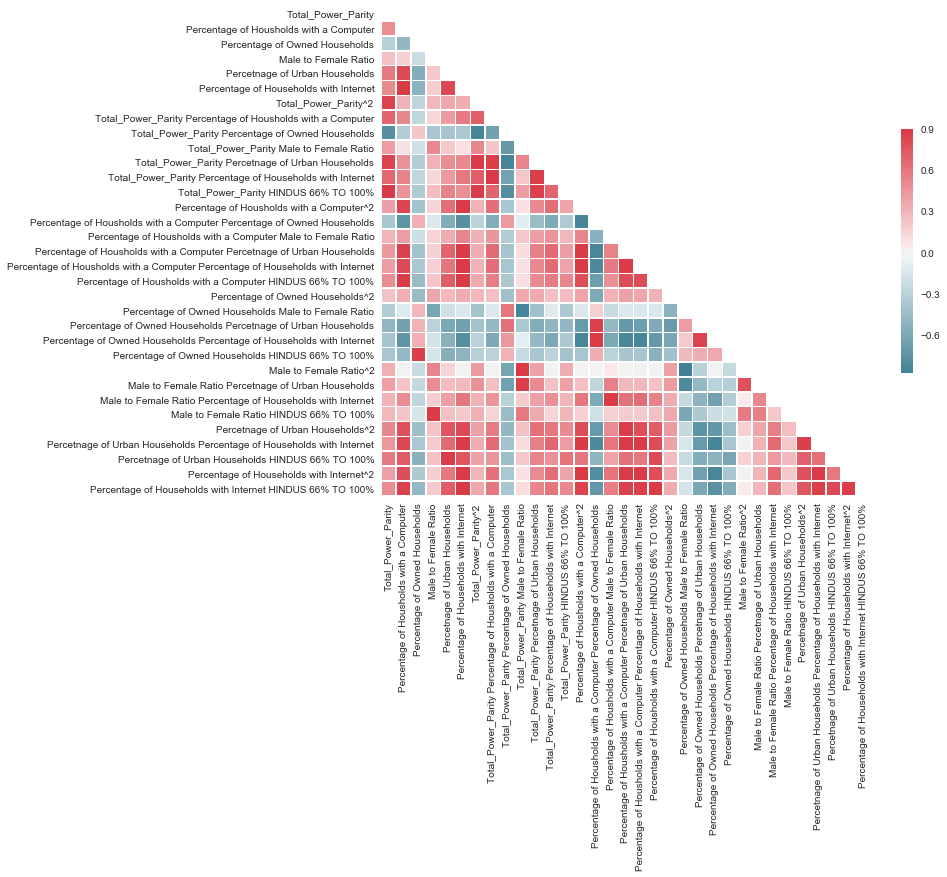

In [35]:
sns.set(style = 'white')

corr = features_selected_train.corr()

mask = np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (11,9))

cmap = sns.diverging_palette(220,10,as_cmap=True)

sns.heatmap(corr,mask=mask,cmap=cmap,vmax=0.9,center=0,square=True,linewidths=0.5,cbar_kws={'shrink' : 0.5})

In [36]:
corr_matrix = features_selected_train.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))


to_drop = [column for column in upper.columns if any(upper[column]>0.95)]

In [37]:
upper

,Total_Power_Parity,Percentage of Housholds with a Computer,Percentage of Owned Households,Male to Female Ratio,Percetnage of Urban Households,Percentage of Households with Internet,Total_Power_Parity^2,Total_Power_Parity Percentage of Housholds with a Computer,Total_Power_Parity Percentage of Owned Households,Total_Power_Parity Male to Female Ratio,...,Percentage of Owned Households HINDUS 66% TO 100%,Male to Female Ratio^2,Male to Female Ratio Percetnage of Urban Households,Male to Female Ratio Percentage of Households with Internet,Male to Female Ratio HINDUS 66% TO 100%,Percetnage of Urban Households^2,Percetnage of Urban Households Percentage of Households with Internet,Percetnage of Urban Households HINDUS 66% TO 100%,Percentage of Households with Internet^2,Percentage of Households with Internet HINDUS 66% TO 100%
Total_Power_Parity,NaN,0.485768,0.310470,0.243694,0.581117,0.510223,0.846819,0.682255,0.775342,0.407015,...,0.380464,0.327434,0.399905,0.304102,0.274590,0.524226,0.443984,0.584811,0.393190,0.490569
Percentage of Housholds with a Computer,NaN,NaN,0.477482,0.163142,0.816077,0.948404,0.312919,0.517968,0.337903,0.089711,...,0.473753,0.028949,0.220076,0.501541,0.218563,0.776061,0.827980,0.730491,0.795255,0.862384
Percentage of Owned Households,NaN,NaN,NaN,0.220766,0.555132,0.514686,0.271899,0.258358,0.217445,0.190951,...,0.869835,0.232616,0.252429,0.261884,0.159705,0.430961,0.372316,0.532216,0.355870,0.481359
Male to Female Ratio,NaN,NaN,NaN,NaN,0.203388,0.178776,0.283928,0.136446,0.379845,0.505728,...,0.163590,0.535174,0.491653,0.176571,0.888943,0.218846,0.186728,0.241476,0.182206,0.193753
Percetnage of Urban Households,NaN,NaN,NaN,NaN,NaN,0.815956,0.352265,0.422793,0.390406,0.184905,...,0.543171,0.147183,0.261033,0.405112,0.240593,0.762835,0.650560,0.885279,0.595539,0.727751
Percentage of Households with Internet,NaN,NaN,NaN,NaN,NaN,NaN,0.331109,0.577233,0.368670,0.097000,...,0.511516,0.036465,0.279472,0.603937,0.201002,0.816316,0.909857,0.757748,0.890791,0.921727
Total_Power_Parity^2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.716943,0.847821,0.520367,...,0.317207,0.421251,0.472309,0.310150,0.321402,0.393812,0.331247,0.393046,0.291824,0.353921
Total_Power_Parity Percentage of Housholds with a Computer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.641842,0.213160,...,0.291890,0.029875,0.239145,0.460040,0.149288,0.569803,0.655574,0.458349,0.618469,0.594168
Total_Power_Parity Percentage of Owned Households,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.701873,...,0.314131,0.619319,0.642217,0.309269,0.456269,0.480095,0.400124,0.430972,0.368925,0.376349
Total_Power_Parity Male to Female Ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.236491,0.939467,0.865894,0.187689,0.590191,0.237555,0.101447,0.205023,0.090076,0.101915


In [38]:
to_drop

['Total_Power_Parity Percentage of Households with Internet',
 'Total_Power_Parity HINDUS 66% TO 100%',
 'Percentage of Housholds with a Computer Percetnage of Urban Households',
 'Percentage of Housholds with a Computer Percentage of Households with Internet',
 'Percentage of Owned Households Percentage of Households with Internet',
 'Male to Female Ratio Percentage of Households with Internet',
 'Percetnage of Urban Households Percentage of Households with Internet',
 'Percentage of Households with Internet^2',
 'Percentage of Households with Internet HINDUS 66% TO 100%']

In [39]:
features_selected_train.drop(columns=to_drop,inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [40]:
model = lr.fit(features_selected_train, y_train)

In [41]:

features_selected_test = features_interactions_test[features_selected_train.columns]
y_pred = model.predict(features_selected_test)

In [42]:
r2 = model.score(features_selected_train, y_train)
# ar2 = 1 - (1-model.score(features_selected_train, y_train))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

In [43]:
r2

0.5012456099862355

In [44]:
cv_5_results = np.mean((cross_val_score(model, features_selected_train, y_train, cv=5)))
cv_10_results = np.mean((cross_val_score(model, features_selected_train, y_train, cv=10)))
cv_20_results = np.mean((cross_val_score(model, features_selected_train, y_train, cv=20)))

In [45]:
print(cv_5_results, cv_10_results, cv_20_results)

0.24454584860797376 0.22105899770479498 0.14144776211046736


In [46]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

In [50]:
def information_selector(X, y, scoring, k=5):
    selector = SelectKBest(score_func=scoring, k=k)
    selector.fit(X, y)
    return X[X.columns[selector.get_support(indices=True)]]

In [51]:
test = SelectKBest(score_func=mutual_info_regression, k=12)
fit = test.fit(features_selected_train, y_train)


In [52]:
features_selected_train = information_selector(features_selected_train, y_train, mutual_info_regression, k=12)

In [54]:
model = lr.fit(features_selected_train, y_train)

In [55]:
features_selected_test = features_interactions_test[features_selected_train.columns]
y_pred = model.predict(features_selected_test)

In [56]:
r2 = model.score(features_selected_train, y_train)

In [57]:
r2

0.4615704269506622

In [58]:
cv_5_results = np.mean((cross_val_score(model, features_selected_train, y_train, cv=5)))
cv_10_results = np.mean((cross_val_score(model, features_selected_train, y_train, cv=10)))
cv_20_results = np.mean((cross_val_score(model, features_selected_train, y_train, cv=20)))

In [59]:
print(cv_5_results, cv_10_results, cv_20_results)

0.4166305796758675 0.4207764622609747 0.39730442578167013
